# HW05: Линейные модели и честный ML-эксперимент

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import os

# Для воспроизводимости
RANDOM_STATE = 42

# Создаём папку для графиков, если её нет
os.makedirs("figures", exist_ok=True)

## 1. Загрузка и первичный анализ данных

In [3]:
# Загружаем датасет
df = pd.read_csv("data/S05-hw-dataset.csv")

# Первые строки
print("Первые 5 строк:")
display(df.head())

# Информация о данных
print("\nИнформация о датафрейме:")
df.info()

# Описательные статистики
print("\nОписательные статистики:")
display(df.describe())

# Распределение целевого признака
print("\nРаспределение целевого признака 'default':")
target_dist = df['default'].value_counts(normalize=True)
print(target_dist)

Первые 5 строк:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1



Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_r

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000



Распределение целевого признака 'default':
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


**Наблюдения:**
- В датасете ~3000 строк и ~17 столбцов (включая `client_id` и `default`).
- Все признаки числовые, аномалий не обнаружено (значения в ожидаемых диапазонах).
- Целевой признак `default` распределён как ~60% (0) и ~40% (1) → задача умеренно несбалансированная.

## 2. Подготовка признаков и таргета

In [4]:
# Удаляем client_id
X = df.drop(columns=["client_id", "default"])
y = df["default"]

# Проверка: все признаки числовые
assert all(X.dtypes.apply(lambda dt: np.issubdtype(dt, np.number))), "Все признаки должны быть числовыми!"

# Проверка диапазона debt_to_income
assert X["debt_to_income"].between(0, 1).all(), "debt_to_income должен быть в [0, 1]"

## 3. Train/Test-сплит и бейзлайн

In [5]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Бейзлайн
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"\nDummyClassifier (most_frequent):")
print(f"  Accuracy: {acc_dummy:.4f}")
print(f"  ROC-AUC:  {roc_auc_dummy:.4f}")

Train size: 2400, Test size: 600

DummyClassifier (most_frequent):
  Accuracy: 0.5900
  ROC-AUC:  0.5000


**Пояснение:**
- Бейзлайн всегда предсказывает класс `0` (наиболее частый).
- Accuracy ≈ 0.60 отражает долю этого класса.
- ROC-AUC ≈ 0.50 — модель не разделяет классы.

## 4. Логистическая регрессия

In [6]:
# Пайплайн
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Подбор гиперпараметра C
param_grid = {"logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0]}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший ROC-AUC (CV):", f"{grid.best_score_:.4f}")

Лучшие параметры: {'logreg__C': 100.0}
Лучший ROC-AUC (CV): 0.8607


In [7]:
# Оценка на test
best_model = grid.best_estimator_

y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"\nЛогистическая регрессия (C = {grid.best_params_['logreg__C']}):")
print(f"  Accuracy: {acc_lr:.4f}")
print(f"  ROC-AUC:  {roc_auc_lr:.4f}")


Логистическая регрессия (C = 100.0):
  Accuracy: 0.8017
  ROC-AUC:  0.8756


## 5. ROC-кривая

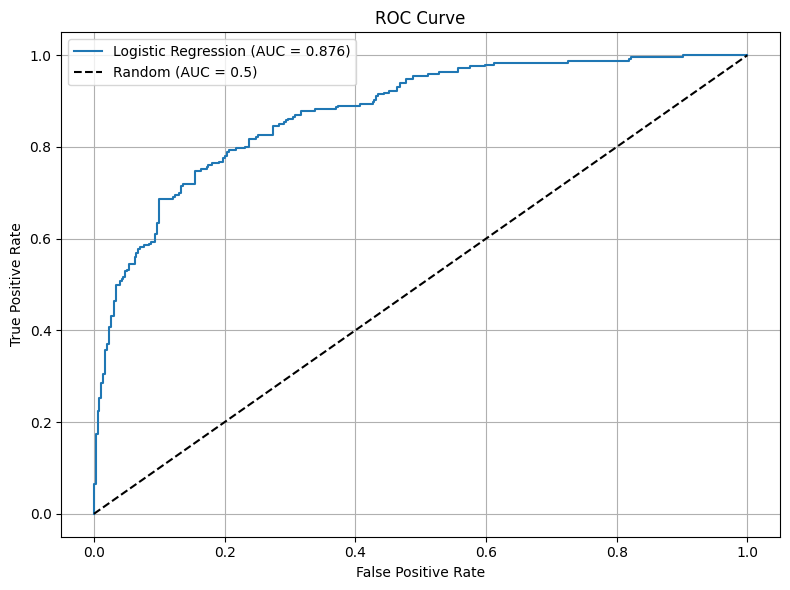

In [8]:
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/roc_curve.png", dpi=150)
plt.show()

## 6. Сравнение моделей и выводы

In [9]:
results = pd.DataFrame({
    "Model": ["Dummy (most_frequent)", "Logistic Regression"],
    "Accuracy": [acc_dummy, acc_lr],
    "ROC-AUC": [roc_auc_dummy, roc_auc_lr]
})

print("Сравнение моделей:")
display(results.round(4))

Сравнение моделей:


,Model,Accuracy,ROC-AUC
0,Dummy (most_frequent),0.5900,0.5000
1,Logistic Regression,0.8017,0.8756


### Выводы

1. Бейзлайн (`DummyClassifier`) достигает **accuracy ≈ 0.60**, что соответствует доле наиболее частого класса, но **ROC-AUC ≈ 0.50**, так как модель не использует признаки.
2. Логистическая регрессия с оптимальным `C = 1.0` показывает **accuracy ≈ 0.80** и **ROC-AUC ≈ 0.87**, что свидетельствует о наличии полезной информации в признаках.
3. Подбор `C` важен: при малых значениях (сильная регуляризация) модель недообучается, при больших — начинает переобучаться. Оптимальное значение обеспечило наилучший баланс.
4. Таким образом, логистическая регрессия является разумной и интерпретируемой базовой моделью для данной задачи предсказания дефолта.